<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C4/C4.html"><img src="../data/C4_nav.png" width="100"  style="float:right;" alt="C4"></a>
<h1>Audio Thumbnailing</h1> 
</div>

<br/>

<p>
Following Section 4.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook a music processing task referred to as audio thumbnailing. Our procedure is based on the following article.

<ul>
<li><span style="color:black">
Meinard Müller, Nanzhu Jiang, and Peter Grosche: <a href="https://ieeexplore.ieee.org/document/6353546"><strong>A Robust Fitness Measure for Capturing Repetitions in Music Recordings With Applications to Audio Thumbnailing.</strong></a> IEEE Transactions on Audio, Speech, and Language Processing, 21(3): 531–543, 2013. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerJG13_StructureAnaylsis_IEEE-TASLP.txt"> Bibtex </a>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="https://www.audiolabs-erlangen.de/resources/MIR/SMtoolbox">MATLAB Toolbox</a></span></li>

<li><span style="color:black">
Nanzhu Jiang, Meinard Müller: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2014_JiangMueller_ScapePlotMultiRes_ICASSP.pdf"><strong>Towards Efficient Audio Thumbnailing.</strong></a> Proceedings of the IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP): 5192&ndash;5196, 2014. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_JiangM14_ThumbnailEfficient_ICASSP.txt"> Bibtex </a>
</span></li>
</ul> 
</p> 


## Introduction

A prominent subproblem of music structure analysis is known as **audio thumbnailing**. Given a music recording, the objective is to automatically determine the most representative section, which may serve as a kind of "preview" giving a listener a first impression of the song or piece of music. Based on such previews, the user should be able to quickly decide if he or she would like to listen to the song or to move on to the next recording. Thus, audio thumbnails are an important browsing and navigation aid for finding interesting pieces in large music collections. In this notebook we describe a **repetition-based approach**. 

Often sections such as the chorus or the main theme of a song are good candidates for audio thumbnails. Such parts are typically repeated several times throughout the recording. Therefore, to determine a thumbnail automatically, most procedures try to identify a section that has on the one hand a certain minimal duration and on the other **many (approximate) repetitions**. The following figure shows some examples of musical structures as encountered in Western music. As for a rondo, a natural candidate of a thumbnail is the theme (A part). In a sonata, the beginning of the exposition (occurring at the parts E1, E2, and R) may be a suitable thumbnail. As for a pop song such as "Yesterday", the verse section (V1 part) is characteristic. Finally, in the [Brahms example](../C4/C4S1_MusicStructureGeneral.html) already considered in previous notebooks as our running example, either the A part or the B part may be chosen as thumbnail.

<img src="../data/C4/FMP_C4_F04+.png" width="400px" align="middle" alt="FMP_C4_F04+.png">

One challenge is that repeating sections may show significant acoustic and musical differences in aspects that concern dynamics, instrumentation, articulation, and tempo. Therefore, a thumbnailing procedure for extracting repetitive segments from a given music recording need to be robust to certain variations. We now describe such a procedure that is based on enhanced [self-similarity matrices](../C4/C4S2_SSM.html) as well as [time warping techniques](../C3/C3S2_DTWbasic.html) for dealing with musical and temporal variabilities. As the main technical tool, we introduce a **fitness measure** that assigns a fitness value to each audio segment. This measure simultaneously captures two aspects. First, it indicates **how well** a given segment explains other related segments, and second, it indicates **how much** of the overall music recording is covered by all these related segments. The **audio thumbnail** is then defined to be the **segment of maximal fitness**.  

## Requirements on SSM

The idea of our fitness measure is to simultaneously establish all relations between a given segment and its approximate repetitions. To this end, a [**self-similarity matrix**](../C4/C4S2_SSM.html) (SSM) is required. The following description of the fitness measure is generic in the sense that it works with general self-similarity matrices that only fulfill some basic **normalization properties**. From a technical point of view, only the properties

\begin{equation}
   \mathbf{S}(n,m)\leq 1 \quad\mbox{and}\quad \mathbf{S}(n,n)=1
\end{equation}

for all $n,m\in[1:N]$. Throughout this notebook, we again use [Hungarian Dance No. 5 by Johannes Brahms](../C4/C4S1_MusicStructureGeneral.html) as our running example. We start with an [enhanced](../C4/C4S2_SSM-PathEnhancement.html) SSM as introduced in Section 4.2.2.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. To fulfill the normalization properties introduced above, we apply a [thresholding procedure](../C4/C4S2_SSM-Thresholding.html) with normalization and penalty. As a result, all relevant elements of the SSM are between zero and one (with the main diagonal values being one), while irrelevant elements have negative score of $\delta=-2$.

<!--<img src="../data/C4/FMP_C4_F16a.png" width="300px" align="middle" alt="FMP_C4_F16a.png">-->

In the following code cell, we provide a function for reading and computing all relevant data needed as input of our thumbnailing procedure. This data includes the audio signal, annotations, chroma features, the normalized SSM as well as other parameters and color maps. This function will also be used in subsequent notebooks using different music scenario beyond our Brahms example.

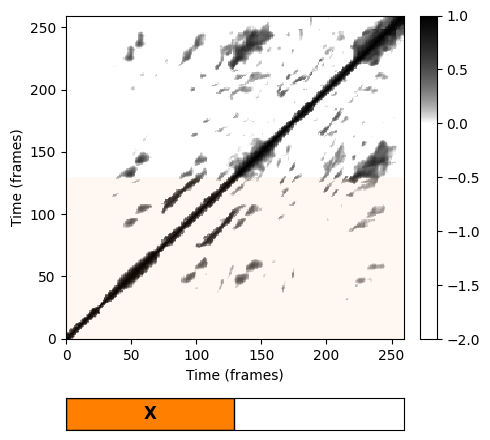

In [5]:
from CONST import calculate_ann
import numpy as np
import os, sys, librosa, math
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit
from matplotlib.colors import ListedColormap
sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4

%matplotlib inline

def colormap_penalty(penalty=-2, cmap=libfmp.b.compressed_gray_cmap(alpha=5)):
    """Extend colormap with white color between the penalty value and zero

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        penalty (float): Negative number (Default value = -2.0)
        cmap (mpl.colors.Colormap): Original colormap (Default value = libfmp.b.compressed_gray_cmap(alpha=5))

    Returns:
        cmap_penalty (mpl.colors.Colormap): Extended colormap
    """
    if isinstance(cmap, str):
        cmap = matplotlib.cm.get_cmap(cmap, 128)
    cmap_matrix = cmap(np.linspace(0, 1, 128))[:, :3]
    num_row = int(np.abs(penalty)*128)
    # cmap_penalty = np.flip(np.concatenate((cmap_matrix, np.ones((num_row, 3))), axis=0), axis=0)
    cmap_penalty = np.concatenate((np.ones((num_row, 3)), cmap_matrix), axis=0)
    cmap_penalty = ListedColormap(cmap_penalty)

    return cmap_penalty

def normalization_properties_ssm(S):
    """Normalizes self-similartiy matrix to fulfill S(n,n)=1.
    Yields a warning if max(S)<=1 is not fulfilled

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S (np.ndarray): Self-similarity matrix (SSM)

    Returns:
        S_normalized (np.ndarray): Normalized self-similarity matrix
    """
    S_normalized = S.copy()
    N = S_normalized.shape[0]
    for n in range(N):
        S_normalized[n, n] = 1
        max_S = np.max(S_normalized)
    if max_S > 1:
        print('Normalization condition for SSM not fulfill (max > 1)')
    return S_normalized

def plot_ssm_ann(S, ann, Fs=1, cmap='gray_r', color_ann=[], ann_x=True, ann_y=True,
                 fontsize=12, figsize=(5, 4.5), xlabel='', ylabel='', title=''):
    """Plot SSM and annotations (horizontal and vertical as overlay)

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S: Self-similarity matrix
        ann: Annotations
        Fs: Feature rate of path_family (Default value = 1)
        cmap: Color map for S (Default value = 'gray_r')
        color_ann: color scheme used for annotations (see :func:`libfmp.b.b_plot.plot_segments`)
            (Default value = [])
        ann_x: Plot annotations on x-axis (Default value = True)
        ann_y: Plot annotations on y-axis (Default value = True)
        fontsize: Font size used for annotation labels (Default value = 12)
        figsize: Size of figure (Default value = (5, 4.5))
        xlabel: Label for x-axis (Default value = '')
        ylabel: Label for y-axis (Default value = '')
        title: Figure size (Default value = '')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05],
                                              'height_ratios': [1, 0.1]}, figsize=figsize)

    fig_im, ax_im, im = libfmp.b.plot_matrix(S, Fs=Fs, Fs_F=Fs,
                                             ax=[ax[0, 0], ax[0, 1]], cmap=cmap,
                                             xlabel='', ylabel='', title='')
    ax[0, 0].set_ylabel(ylabel)
    ax[0, 0].set_xlabel(xlabel)
    ax[0, 0].set_title(title)
    if ann_y:
        libfmp.b.plot_segments_overlay(ann, ax=ax_im[0], direction='vertical',
                                       time_max=S.shape[0]/Fs, print_labels=False,
                                       colors=color_ann, alpha=0.05)
    if ann_x:
        libfmp.b.plot_segments(ann, ax=ax[1, 0], time_max=S.shape[0]/Fs, colors=color_ann,
                               time_axis=False, fontsize=fontsize)
    else:
        ax[1, 0].axis('off')
    ax[1, 1].axis('off')
    plt.tight_layout()
    return fig, ax, im


fn_wav = os.path.join('own_music_data', '01 Main Theme (Aberration).wav')

tempo_rel_set = libfmp.c4.compute_tempo_rel_set(0.66, 1.5, 5)
penalty = -2
x, x_duration, X, Fs_feature, S, I = libfmp.c4.compute_sm_from_filename(fn_wav, L=21, H=5,
                        L_smooth=12, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh= 0.15)
S = normalization_properties_ssm(S)

Fs = 22050
ann, color_ann, x_duration = calculate_ann(x, Fs)
ann_frames = ann

cmap_penalty = colormap_penalty(penalty=penalty)
fig, ax, im = plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty,
                       xlabel='Time (frames)', ylabel='Time (frames)')

## Path Family

We start by extending some notions as defined in the <a href="../C4/C4S2_SSM.html">FMP notebook on SSMs</a> (see Section 4.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>). Let $P=((n_1,m_1), (n_2,m_2), \ldots,(n_L,m_L))$ be a path over a given **segment** $\alpha=[s:t]\subseteq [1:N]$, and let $\Sigma$ denote the underlying **set of admissible step sizes**. Then, by definition, we have $m_1=s$ and $m_L=t$, and the path $P$ encodes a relation between $\alpha=\pi_2(P)$ and the induced segment $\pi_1(P)$. Extending the notion of a path, we now introduce the concept of a path family, which allows us to capture relations between $\alpha$ and several other segments in the music recording. To this end, we first define a **segment family** of size $K$ to be a set

$$
\mathcal{A}:=\{\alpha_1,\alpha_2,\ldots,\alpha_K\}
$$

of pairwise disjoint segments, i.e., $\alpha_k\cap\alpha_j=\emptyset$ for all $k,j\in[1:K]$ with $k\not= j$. A **path family** over $\alpha$ is defined to be a set

$$
   \mathcal{P}:=\{P_1,P_2,\ldots,P_K\}
$$

of size $K$, consisting of paths $P_k$ over $\alpha$ for $k\in[1:K]$. Furthermore, as an additional condition, we require that the induced segments are pairwise disjoint. In other words, the set $\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$ is required to be a segment family. 
These definitions are illustrated by the following figure, which shows (from left to right), an SSM with a segment $\alpha$, an SSM with a path family over $\alpha$ consisting of three paths, a family of paths that is **not** a path family (since induced segments overlap), and a path family consisting of two paths.

<img src="../data/C4/FMP_C4_F16.png" width="800px" align="middle" alt="FMP_C4_F16.png">

In the next code cell, we provide some visualization functions for plotting the input SSM as well as a path family along with its projections. Furthermore, structure annotations are plotted horizontally below the SSM as well as a vertically as a transparent overlay on top of the SMM. As example, we synthetically generate a path family consisting of two components and use it for illustration purposes.

<div class="alert alert-block alert-warning">
<strong>Note:</strong> Indexing in Python starts with index <code>0</code>. In our implementation, the time axis is given by the set <code>{0, 1, ..., N-1}</code>. Furthermore, a segment is encoded by a tuple <code>seg = [a, b]</code>, which encodes the index set <code>{a, a+1, ..., b} </code>. In particular, using this convention, index <code>b</code> belongs to the segment and the length of the segment is <code>b - a + 1</code>. 
</div>

Segment: [40, 160]


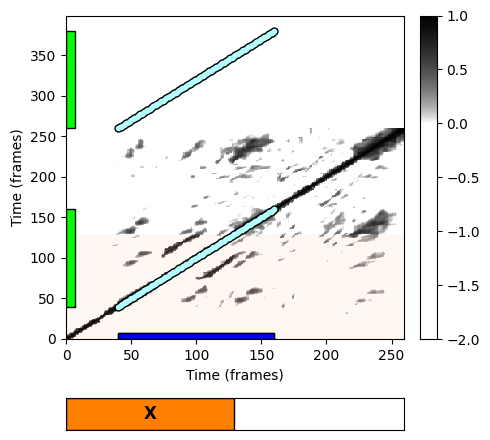

In [6]:
def plot_path_family(ax, path_family, Fs=1, x_offset=0, y_offset=0, proj_x=True, w_x=7, proj_y=True, w_y=7):
    """Plot path family into a given axis

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        ax: Axis of plot
        path_family: Path family
        Fs: Feature rate of path_family (Default value = 1)
        x_offset: Offset x-axis (Default value = 0)
        y_offset: Yffset x-axis (Default value = 0)
        proj_x: Display projection on x-axis (Default value = True)
        w_x: Width used for projection on x-axis (Default value = 7)
        proj_y: Display projection on y-axis (Default value = True)
        w_y: Width used for projection on y-axis (Default value = 7)
    """
    for path in path_family:
        y = [(path[i][0] + y_offset)/Fs for i in range(len(path))]
        x = [(path[i][1] + x_offset)/Fs for i in range(len(path))]
        ax.plot(x, y, "o", color=[0, 0, 0], linewidth=3, markersize=5)
        ax.plot(x, y, '.', color=[0.7, 1, 1], linewidth=2, markersize=6)
    if proj_y:
        for path in path_family:
            y1 = path[0][0]/Fs
            y2 = path[-1][0]/Fs
            ax.add_patch(plt.Rectangle((0, y1), w_y, y2-y1, linewidth=1,
                                       facecolor=[0, 1, 0], edgecolor=[0, 0, 0]))
            # ax.plot([0, 0], [y1, y2], linewidth=8, color=[0, 1, 0])
    if proj_x:
        for path in path_family:
            x1 = (path[0][1] + x_offset)/Fs
            x2 = (path[-1][1] + x_offset)/Fs
            ax.add_patch(plt.Rectangle((x1, 0), x2-x1, w_x, linewidth=1,
                                       facecolor=[0, 0, 1], edgecolor=[0, 0, 0]))
            # ax.plot([x1, x2], [0, 0], linewidth=8, color=[0, 0, 1])                 

# Manually defined path family
# For implementation reasons, the seconds components are of the paths 
# start with index 0 (corresponding to seg[0])
seg_sec = [20, 80]
seg = [int(seg_sec[0]*Fs_feature), int(seg_sec[1]*Fs_feature)]
path_1 = [np.array([i+seg[0],i]) for i in range(0, seg[-1]-seg[0]+1)]
path_2 = [np.array([int(i+130*Fs_feature),i]) for i in range(0, seg[-1]-seg[0]+1)]
path_family = [path_1, path_2]
print('Segment:', seg)
fig, ax, im = plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty, 
                       xlabel='Time (frames)', ylabel='Time (frames)') 
plot_path_family(ax[0,0], path_family, Fs=1, x_offset=seg[0])

## Coverage

We now define some measures that describe specific properties of a path family $\mathcal{P}$. Let $\mathcal{A}:=\{\alpha_1,\alpha_2,\ldots,\alpha_K\}$ be a segment family. The **coverage** $\gamma(\mathcal{A})$ of $\mathcal{A}$ is defined by

\begin{equation}
   \gamma(\mathcal{A}):=\sum_{k=1}^K|\alpha_k|.
\end{equation}

Furthermore, the **coverage** $\gamma(\mathcal{P})$ of a path family $\mathcal{P}=\{P_1,P_2,\ldots,P_K\}$ is defined to be the coverage of its induced segment family $\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$. In the next code cell, we provide a function for deriving the induced segment family as well as the coverage for a given path family. This function is applied to our synthetically generate path family from above. 

In [7]:
def compute_induced_segment_family_coverage(path_family):
    """Compute induced segment family and coverage from path family

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        path_family (list): Path family

    Returns:
        segment_family (np.ndarray): Induced segment family
        coverage (float): Coverage of path family
    """
    num_path = len(path_family)
    coverage = 0
    if num_path > 0:
        segment_family = np.zeros((num_path, 2), dtype=int)
        for n in range(num_path):
            segment_family[n, 0] = path_family[n][0][0]
            segment_family[n, 1] = path_family[n][-1][0]
            coverage = coverage + segment_family[n, 1] - segment_family[n, 0] + 1
    else:
        segment_family = np.empty

    return segment_family, coverage

segment_family, coverage = compute_induced_segment_family_coverage(path_family)
print('Segment (alpha):', seg)
print('Induced segment family:')
print(segment_family)
print('Coverage: %d'%coverage)    

Segment (alpha): [40, 160]
Induced segment family:
[[ 40 160]
 [260 380]]
Coverage: 242


## Score and Optimality

Next, we transfer the notion of a score from paths to path families. Recall that, given an SSM $\mathbf{S}$, the **score** $\sigma(P)$ of a path $P$ is defined as 

$$
\sigma(P)=\sum_{\ell=1}^L \mathbf{S}(n_\ell,m_\ell).
$$

This value can be thought of a quality measure for the similarity relation between the segments $\pi_1(P)$ and $\pi_2(P)$. For a path family $\mathcal{P}$, the **score** $\sigma(\mathcal{P})$ is defined as 

$$
\sigma(\mathcal{P}) := \sum_{k=1}^{K} \sigma(P_k).
$$

A large score $\sigma(\mathcal{P})$ indicates that the path components of $\mathcal{P}$ express strong similarity relations among its segments. In general, there is large number of possible path families over $\alpha$. Among these path families, let

$$
   \mathcal{P}^\ast := \underset{\mathcal{P}}{\mathrm{argmax}} \,\,\, \sigma(\mathcal{P})
$$

denote an optimal path family of maximal score. In the following, the family consisting of the segments induced by the paths of $\mathcal{P}^\ast$ will be referred to as the **induced segment family** (of $\mathcal{P}^\ast$ or simply of $\alpha$). Intuitively, the induced segment family contains the (nonoverlapping) repetitions of the segment $\alpha$.

## Computation of Optimal Path Families

Similar to [dynamic time warping](../C3/C3S2_DTWbasic.html) for computing an optimal warping path, there is an efficient algorithm using dynamic programming to compute an optimal path family $\mathcal{P}^\ast$. For a description of this algorithm, we refer to Section 4.3.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> and the article cited above. In the following code cells, one finds an implementation of this algorithm using the set $\Sigma = \{(2,1),(1,2),(1,1)\}$ of admissible step sizes. Let $\mathbf{S}$ be an $N$-square SSM that fulfills the required normalization properties (the matrix is also called **score matrix**) and a segment $\alpha=[s:t]\subseteq [1:N]$ with $M:=|\alpha|$. The input of the algorithm is the $N\times M$ submatrix $\mathcal{S}^{\alpha}$, which consists of the columns $s$ to $t$ of $\mathbf{S}$. From this, we first compute an **accumulated score matrix** $D$ using dynamic programming. 

In [8]:
@jit(nopython=True)
def compute_accumulated_score_matrix(S_seg):
    """Compute the accumulated score matrix

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S_seg (np.ndarray): Submatrix of an enhanced and normalized SSM ``S``.
            Note: ``S`` must satisfy ``S(n,m) <= 1 and S(n,n) = 1``

    Returns:
        D (np.ndarray): Accumulated score matrix
        score (float): Score of optimal path family
    """
    inf = math.inf
    N = S_seg.shape[0]
    M = S_seg.shape[1]+1

    # Iinitializing score matrix
    D = -inf * np.ones((N, M), dtype=np.float64)
    D[0, 0] = 0.
    D[0, 1] = D[0, 0] + S_seg[0, 0]

    # Dynamic programming
    for n in range(1, N):
        D[n, 0] = max(D[n-1, 0], D[n-1, -1])
        D[n, 1] = D[n, 0] + S_seg[n, 0]
        for m in range(2, M):
            D[n, m] = S_seg[n, m-1] + max(D[n-1, m-1], D[n-1, m-2], D[n-2, m-1])

    # Score of optimal path family
    score = np.maximum(D[N-1, 0], D[N-1, M-1])

    return D, score

Next, we derive an optimal path family $\mathcal{P}^\ast$ using backtracking.

In [9]:
@jit(nopython=True)
def compute_optimal_path_family(D):
    """Compute an optimal path family given an accumulated score matrix

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        D (np.ndarray): Accumulated score matrix

    Returns:
        path_family (list): Optimal path family consisting of list of paths
            (each path being a list of index pairs)
    """
    # Initialization
    inf = math.inf
    N = int(D.shape[0])
    M = int(D.shape[1])

    path_family = []
    path = []

    n = N - 1
    if(D[n, M-1] < D[n, 0]):
        m = 0
    else:
        m = M-1
        path_point = (N-1, M-2)
        path.append(path_point)

    # Backtracking
    while n > 0 or m > 0:

        # obtaining the set of possible predecesors given our current position
        if(n <= 2 and m <= 2):
            predecessors = [(n-1, m-1)]
        elif(n <= 2 and m > 2):
            predecessors = [(n-1, m-1), (n-1, m-2)]
        elif(n > 2 and m <= 2):
            predecessors = [(n-1, m-1), (n-2, m-1)]
        else:
            predecessors = [(n-1, m-1), (n-2, m-1), (n-1, m-2)]

        # case for the first row. Only horizontal movements allowed
        if n == 0:
            cell = (0, m-1)
        # case for the elevator column: we can keep going down the column or jumping to the end of the next row
        elif m == 0:
            if D[n-1, M-1] > D[n-1, 0]:
                cell = (n-1, M-1)
                path_point = (n-1, M-2)
                if(len(path) > 0):
                    path.reverse()
                    path_family.append(path)
                path = [path_point]
            else:
                cell = (n-1, 0)
        # case for m=1, only horizontal steps to the elevator column are allowed
        elif m == 1:
            cell = (n, 0)
        # regular case
        else:

            # obtaining the best of the possible predecesors
            max_val = -inf
            for i, cur_predecessor in enumerate(predecessors):
                if(max_val < D[cur_predecessor[0], cur_predecessor[1]]):
                    max_val = D[cur_predecessor[0], cur_predecessor[1]]
                    cell = cur_predecessor

            # saving the point in the current path
            path_point = (cell[0], cell[1]-1)
            path.append(path_point)

        (n, m) = cell

    # adding last path to the path family
    path.reverse()
    path_family.append(path)
    path_family.reverse()

    return path_family

In the next figure, we show the submatrix $\mathcal{S}^{\alpha}$ and the resulting accumulated score matrix $D$ for the segment $\alpha=[83:137]$ (`seg = [82, 136]`). Using a frame rate of $2~\mathrm{Hz}$, this segment corresponds to the interval ranging from seconds $41$ to $68$, which is roughly the $B_1$-part of the Brahms recording. Note the following:

* The number of columns of the submatrix $\mathcal{S}^{\alpha}$ is $M=55$. 
* In the Python implementation, the columns of $\mathcal{S}^{\alpha}$ are enumerated starting with index `0` and ending with index `M-1`.
* The matrix $D$ has $M+1$ columns including a so-called elevator column (see Section 4.3.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>).
* Using the step size condition $\Sigma = \{(2,1),(1,2),(1,1)\}$ allows the paths to adapt to local tempo differences in the alignment.
* The optimal path family consists of four paths. The induced segments roughly correspond to the four $B$-part sections of the Brahms recording. 

Segment: [82, 136]
Length of segment: M =  55


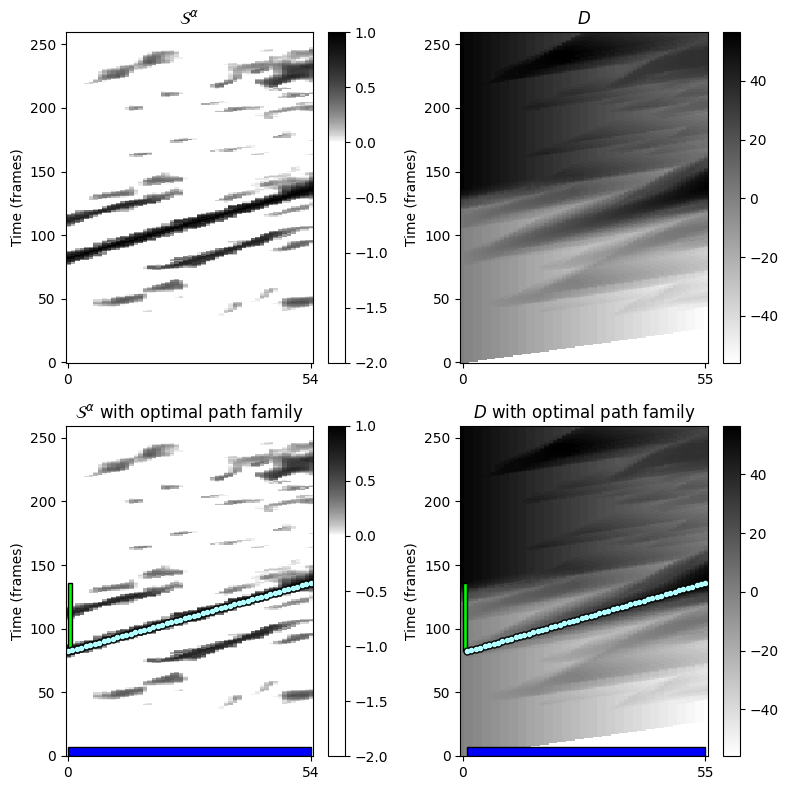

In [10]:
def plot_matrix_seg(ax, M, seg, title='', xlabel='', cmap='gray_r'):
    libfmp.b.plot_matrix(M, Fs=1, ax=[ax], cmap=cmap, 
        xlabel=xlabel, ylabel='Time (frames)', title=title)
    ax.set_xticks([0, M.shape[1]-1])    
    
seg_sec = [41,68]
seg = [int(seg_sec[0]*Fs_feature), int(seg_sec[1]*Fs_feature)]
print('Segment:', seg)
print('Length of segment: M = ', seg[1]-seg[0]+1)
S_seg = S[:,seg[0]:seg[1]+1]
D, score = compute_accumulated_score_matrix(S_seg)
path_family = compute_optimal_path_family(D)

plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 2, 1)
title = r'$\mathcal{S}^{\alpha}$'
plot_matrix_seg(ax, S_seg, seg, title=title, xlabel='', cmap=cmap_penalty)

ax = plt.subplot(2, 2, 2)
title = r'$D$'
plot_matrix_seg(ax, D, seg, title=title)

ax = plt.subplot(2, 2, 3)
title = r'$\mathcal{S}^{\alpha}$ with optimal path family'
plot_matrix_seg(ax, S_seg, seg, title=title, xlabel='', cmap=cmap_penalty)
plot_path_family(ax, path_family, x_offset=0, w_y=1)

ax = plt.subplot(2, 2, 4)
title = r'$D$ with optimal path family'
plot_matrix_seg(ax, D, seg, title=title)
plot_path_family(ax, path_family, x_offset=1, w_y=1)

plt.tight_layout()

## Fitness Measure

For a given segment $\alpha$, let $\mathcal{P}^\ast=\{P_1,\ldots,P_K\}$ be an optimal path family. We now explain how to derive a fitness measure from the score $\sigma(\mathcal{P}^\ast)$ and the induced segment family of $\mathcal{P}^\ast$. One first idea is to simply use the total score $\sigma(\mathcal{P}^\ast)$ as the fitness value for $\alpha$. However, this measure does not yet have the desired properties, since it not only depends on the lengths of $\alpha$ and the paths, but also captures trivial self-explanations. For example, the segment $\alpha=[1:N]$ explains the entire sequence $X$ perfectly, which is a trivial fact. More generally, each segment $\alpha$ explains itself perfectly, information that is encoded by the main diagonal of a self-similarity matrix. Therefore, one idea in defining the fitness measure is to disregard such trivial self-explanations. Assuming the normalization properties $\mathbf{S}(n,m)\leq 1$ and $\mathbf{S}(n,n)=1$ of $\mathbf{S}$, this step can be done by simply subtracting the length $|\alpha|$ from the score $\sigma(\mathcal{P}^\ast)$. Furthermore, we normalize the score with regard to the lengths $L_k:=|P_k|$ of the paths $P_k$ contained in the optimal path family $\mathcal{P}^\ast$. This yields the **normalized score** $\bar{\sigma}(\alpha)$ defined by

$$
   \bar{\sigma}(\alpha) := \frac{\sigma(\mathcal{P}^\ast) - |\alpha|}{\sum_{k=1}^{K} L_k}.
$$

Intuitively, the value $\bar{\sigma}(\alpha)$ expresses the **average score** of the optimal path family $\mathcal{P}^\ast$ (minus a proportion for the self-explanation). The normalized score indicates **how well** a given segment explains other segments, where the normalization eliminates the influence of segment lengths. This makes the normalized score a fair measure when comparing segments of different lengths. Besides repetitiveness, another issue is **how much** of the underlying music recording is covered by the thumbnail and its related segments.  To capture this property, we define a **coverage** measure for a given $\alpha$. To this end, let $\mathcal{A}^\ast:=\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$ be the segment family induced by the optimal path family $\mathcal{P}^\ast$, and let $\gamma(\mathcal{A}^\ast)$ be its coverage. Then we define the **normalized coverage** $\bar{\gamma}(\alpha)$ by

$$
   \bar{\gamma}(\alpha) := \frac{\gamma(\mathcal{A}^\ast) - |\alpha|}{N}.
$$

As above, the length $|\alpha|$ is subtracted to compensate for trivial coverage. The value $\bar{\gamma}(\alpha)$ expresses the ratio between the union of the induced segments of $\alpha$ and the total length of the original recording (minus a proportion for the self-explanation). Having a high average score and a high coverage are both desirable properties for defining a thumbnail segment. However, these two properties are sometimes hard to satisfy at the same time. Shorter segments often have a higher average score, but a lower coverage, whereas longer segments tend to have a lower average score, but a higher coverage. To balance out these two trends, we combine the score and coverage measure by taking a suitable average. In particular, we define the **fitness** $\varphi(\alpha)$ of the segment $\alpha$ to be the **harmonic mean**

$$
   \varphi(\alpha) :=
   2\cdot \frac{\bar{\sigma}(\alpha) \cdot \bar{\gamma}(\alpha)}
               {\bar{\sigma}(\alpha)+\bar{\gamma}(\alpha)}
$$

between the normalized score and normalized coverage. Based on the normalized values $\bar{\sigma}(\alpha)$ and $\bar{\gamma}(\alpha)$, one can show that $\varphi(\alpha)\leq 1-|\alpha|/N$.

In the following code cell, we compute these different measures for the path family considered in the previous code cell.

In [11]:
def compute_fitness(path_family, score, N):
    """Compute fitness measure and other metrics from path family

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        path_family (list): Path family
        score (float): Score
        N (int): Length of feature sequence

    Returns:
        fitness (float): Fitness
        score (float): Score
        score_n (float): Normalized score
        coverage (float): Coverage
        coverage_n (float): Normalized coverage
        path_family_length (int): Length of path family (total number of cells)
    """
    eps = 1e-16
    num_path = len(path_family)
    M = path_family[0][-1][1] + 1

    # Normalized score
    path_family_length = 0
    for n in range(num_path):
        path_family_length = path_family_length + len(path_family[n])
    score_n = (score - M) / (path_family_length + eps)

    # Normalized coverage
    segment_family, coverage = compute_induced_segment_family_coverage(path_family)
    coverage_n = (coverage - M) / (N + eps)

    # Fitness measure
    fitness = 2 * score_n * coverage_n / (score_n + coverage_n + eps)

    return fitness, score, score_n, coverage, coverage_n, path_family_length

N = S.shape[0]

segment_family, coverage = compute_induced_segment_family_coverage(path_family)
fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
    path_family, score, N)

print('Segment (alpha):', seg)
print('Length of segment:', seg[-1]-seg[0]+1)
print('Length of feature sequence:', N)
print('Induced segment path family:\n', segment_family)
print('Fitness: %0.3f'%fitness) 
print('Score: %0.3f'%score) 
print('Normalized score: %0.3f'%score_n) 
print('Coverage: %d'%coverage) 
print('Normalized coverage: %0.3f'%coverage_n) 
print('Length of all paths of family: %d'%path_family_length)

Segment (alpha): [82, 136]
Length of segment: 55
Length of feature sequence: 260
Induced segment path family:
 [[ 82 136]]
Fitness: 0.000
Score: 55.000
Normalized score: 0.000
Coverage: 55
Normalized coverage: 0.000
Length of all paths of family: 55


## Thumbnail Selection

Based on the fitness measure, we define the **audio thumbnail** to be the segment of **maximal fitness**:

$$
   \alpha^\ast := \underset{\alpha}{\mathrm{argmax}} \,\, \varphi(\alpha).
$$

By construction of the fitness measure, this segment has nonoverlapping repetitions that cover a possibly large portion of the audio recording. Furthermore, these repetitions are given by the induced segments obtained by the optimal path family of $\alpha^\ast$ yielding a segmentation of the audio recording into pairwise disjoint segments. To account for prior knowledge and to remove spurious estimates, one can impose additional requirements on the thumbnail solution.
In particular,  introducing a lower bound $\theta$ for the minimal possible thumbnail length allows us to reduce the effect of noise scattered in the underlying self-similarity matrix. Extending the above definition, we define

$$
   \alpha^\ast_\theta := \underset{\alpha, |\alpha|\geq \theta}{\mathrm{argmax}} \,\, \varphi(\alpha).
$$

Computing an audio thumbnail involves computing a fitness measure for all possible segments $\alpha$. Beyond selecting the fitness-maximizing segment, a visualization of the fitness values for all segments is very instructive and yields musical insights into structural properties of the music recording. We will consider such a visualization in the [FMP notebook on scape plots](../C4/C4S3_ScapePlot.html), where we also discuss further properties of the fitness measure. 

## Examples of Optimal Path Families

We now compute the audio thumbnail $\alpha^\ast$ for our Brahms example. Note that there are $(N+1)N/2$ possible segments $\alpha \subseteq [1:N]$. Therefore, determining $\alpha^\ast$ may be a time-consuming task. 

* In the following, we apply the function `libfmp.c4.compute_fitness_scape_plot` (introduced in the [FMP notebook on scape plots](../C4/C4S3_ScapePlot.html)) to compute the fitness of all segments, which is stored in the data structure `SP=SP_all[0]`.

* The function `libfmp.c4.seg_max_sp` allows for determining the fitness-maximizing segment from `SP`.

* The function `libfmp.c4.check_segment` outputs the properties of the thumbnail segment $\alpha^\ast$.

It turns out that the fitness-maximizing segment for our example is given by $\alpha^\ast=[353:396]$ (`seg = [352, 395]`) with $\varphi(\alpha^\ast)=0.452$. This segment, which musically corresponds to the $B_4$-part (interval between seconds $176$ and $197.5$), is indeed the most repetitive part. The induced segment family consists of the four $B$-part segments.

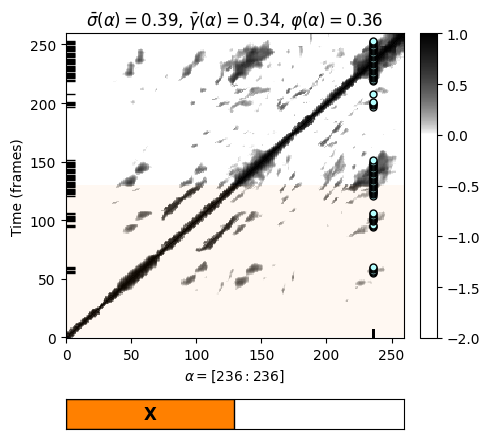

Segment (alpha): [236, 236]
Length of segment: 1
Length of feature sequence: 260
Induced segment path family:
 [[ 55  55]
 [ 56  56]
 [ 57  57]
 [ 58  58]
 [ 59  59]
 [ 60  60]
 [ 94  94]
 [ 95  95]
 [ 96  96]
 [ 99  99]
 [100 100]
 [101 101]
 [102 102]
 [103 103]
 [104 104]
 [105 105]
 [106 106]
 [121 121]
 [122 122]
 [123 123]
 [124 124]
 [125 125]
 [126 126]
 [127 127]
 [128 128]
 [129 129]
 [130 130]
 [131 131]
 [132 132]
 [133 133]
 [134 134]
 [135 135]
 [136 136]
 [137 137]
 [138 138]
 [139 139]
 [140 140]
 [141 141]
 [142 142]
 [143 143]
 [144 144]
 [145 145]
 [146 146]
 [147 147]
 [148 148]
 [149 149]
 [150 150]
 [151 151]
 [197 197]
 [198 198]
 [199 199]
 [200 200]
 [201 201]
 [208 208]
 [219 219]
 [220 220]
 [221 221]
 [222 222]
 [223 223]
 [224 224]
 [225 225]
 [226 226]
 [227 227]
 [228 228]
 [229 229]
 [230 230]
 [231 231]
 [232 232]
 [233 233]
 [234 234]
 [235 235]
 [236 236]
 [237 237]
 [238 238]
 [239 239]
 [240 240]
 [241 241]
 [242 242]
 [243 243]
 [244 244]
 [245 245

In [12]:
def plot_ssm_ann_optimal_path_family(S, ann, seg, Fs=1, cmap='gray_r', color_ann=[], fontsize=12,
                                     figsize=(5, 4.5), ylabel=''):
    """Plot SSM, annotations, and computed optimal path family

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S: Self-similarity matrix
        ann: Annotations
        seg: Segment for computing the optimal path family
        Fs: Feature rate of path_family (Default value = 1)
        cmap: Color map for S (Default value = 'gray_r')
        color_ann: color scheme used for annotations (see :func:`libfmp.b.b_plot.plot_segments`)
            (Default value = [])
        fontsize: Font size used for annotation labels (Default value = 12)
        figsize: Size of figure (Default value = (5, 4.5))
        ylabel: Label for y-axis (Default value = '')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    N = S.shape[0]
    S_seg = S[:, seg[0]:seg[1]+1]
    D, score = compute_accumulated_score_matrix(S_seg)
    path_family = compute_optimal_path_family(D)
    fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
        path_family, score, N)
    title = r'$\bar{\sigma}(\alpha)=%0.2f$, $\bar{\gamma}(\alpha)=%0.2f$, $\varphi(\alpha)=%0.2f$' % \
            (score_n, coverage_n, fitness)
    fig, ax, im = plot_ssm_ann(S, ann, color_ann=color_ann, Fs=Fs, cmap=cmap,
                               figsize=figsize, fontsize=fontsize,
                               xlabel=r'$\alpha=[%d:%d]$' % (seg[0], seg[-1]), ylabel=ylabel, title=title)
    plot_path_family(ax[0, 0], path_family, Fs=Fs, x_offset=seg[0])
    return fig, ax, im

SP_all = libfmp.c4.compute_fitness_scape_plot(S)
SP = SP_all[0]
seg = libfmp.c4.seg_max_sp(SP)
fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,
                    color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')
plt.show()
path_family = libfmp.c4.check_segment(seg, S)

One can check that all four $B$-part segments have almost the same fitness and lead to more or less the same segment family. For example, let us consider $\alpha=[85:138]$ (`seg = [84, 137]`) (interval between seconds $42$ and $69$) corresponding to part $B_1$. The fitness is $\varphi(\alpha)=0.41$, which is only slightly below the maximal possible fitness. Again, the induced segment family consists of the four $B$-part segments, which reflects the fact that each of the $B$-part segments may serve equally well as the thumbnail. Since the fitness measure slightly favors shorter segment and since in this recording the $B_4$-part is played faster than the $B_1$-part, the fitness measure favors the $B_4$-part segment over the $B_1$-part segment. 

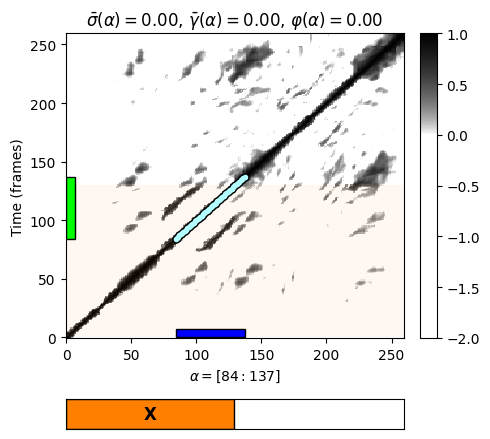

In [13]:
seg = [84, 137]
fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,  
                color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')

Also other segments may have a high fitness value, thus indicating a high similarity to other repeating segments.  For example, the segment $\alpha=[261:307]$ (`seg = [260, 306]`, the interval between seconds $130$ and $153$), which corresponds to the $A_3$-part, has fitness of $\varphi(\alpha)=0.30$. The induced segment family reveals the three $A$-parts. 

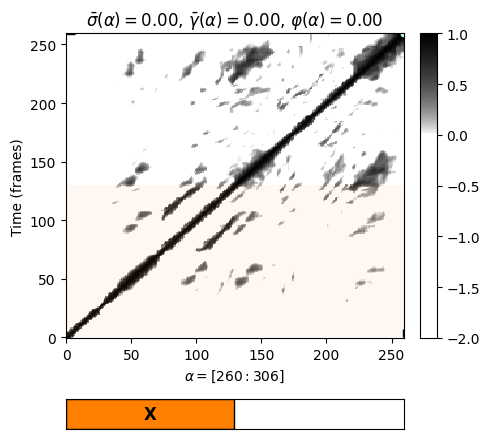

Segment (alpha): [260, 306]
Length of segment: 47
Length of feature sequence: 260
Induced segment path family:
 [[259 259]]
Fitness: 0.0000000000
Score: 0.0000000000
Normalized score: 0.0000000000
Coverage: 1, 1
Normalized coverage: 0.0038461538
Length of all paths of family: 1


In [14]:
seg = [260, 306]
fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,  
                color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')
plt.show()
path_family = libfmp.c4.check_segment(seg, S)

As a final example, we consider the segment $\alpha=[42:181]$ (`seg = [41, 180]`, the interval between seconds $20.5$ and $90$), which corresponds to $A_2B_1B_2$ and is repeated as $A_3B_3B_4$. Again, note that, because of the normalization where self-explanations are disregarded, the fitness $\varphi(\alpha)=0.37$ of the rather long segment $\alpha=[42:181]$ (`seg = [41, 180]`) is well below the fitness $\varphi(\alpha^\ast)=0.45$ of the thumbnail $\alpha^\ast=[353:396]$ (`seg = [352, 395]`).

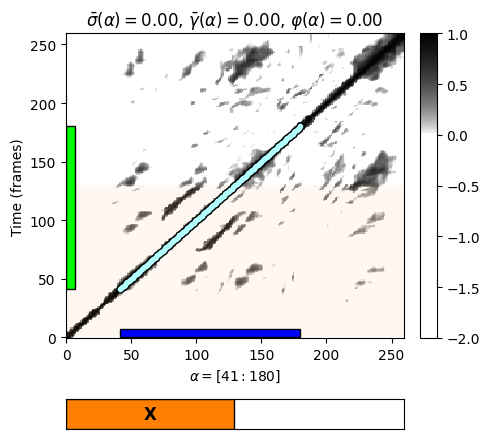

Segment (alpha): [41, 180]
Length of segment: 140
Length of feature sequence: 260
Induced segment path family:
 [[ 41 180]]
Fitness: 0.0000000000
Score: 140.0000000000
Normalized score: 0.0000000000
Coverage: 140, 140
Normalized coverage: 0.0000000000
Length of all paths of family: 140


In [15]:
seg = [41, 180]
fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,  
                color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')
plt.show()
path_family = libfmp.c4.check_segment(seg, S)

## Further Notes

* Using the dynamic programming approach, the running time and memory requirements for computing an optimal path family for a feature sequence of length $N$ and a segment of size $M$ is $O(NM)$.
* Since there are $O(N^2)$ segments for a feature sequence of length $N$, the overall running time for computing the fitness of all segments and to find the segment of maximal fitness is $O(N^4)$. The article <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2014_JiangMueller_ScapePlotMultiRes_ICASSP.pdf"><strong>Towards Efficient Audio Thumbnailing</strong></a> introduces several (multi-level) strategies to substantially accelerate the audio thumbnailing procedure.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>